In [1]:
!pip install tensorflow

In [2]:
!pip install causalml



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1


In [3]:
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.tf import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

import os, sys

%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [6]:

# -------------------------
# 0) 데이터 로드
# -------------------------
df_raw = pd.DataFrame()
for i in range(1, 10):
    url = f"https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_{i}.csv"
    data = pd.read_csv(url, header=None)
    df_raw = pd.concat([data, df_raw], ignore_index=True)

cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [f'x{i}' for i in range(1,26)]
df_raw.columns = cols
print("Loaded:", df_raw.shape)


Loaded: (6723, 30)


In [7]:
df_raw.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,49.647921,34.950762,37.173291,50.383798,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,16.073412,49.435313,16.087249,49.546234,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,19.643007,48.598210,18.044855,49.661068,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,26.368322,49.715204,24.605964,49.971196,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,20.258893,51.147418,20.612816,49.794120,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [8]:
pd.Series(df_raw['treatment']).value_counts(normalize=True)

,proportion
treatment,
0,0.813922
1,0.186078


In [9]:
X = df_raw.loc[:,'x1':]
treatment = df_raw['treatment']
y = df_raw['y_factual']
tau = df_raw.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1
               else d['y_cfactual'] - d['y_factual'],
               axis=1)
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, treatment)

In [10]:
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 6723, number of used features: 26
[LightGBM] [Info] Start training from score 8.876582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 6723, number of used features: 26
[LightGBM] [Info] Start training from score 8.876582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

### **Dragonnet: 치료 효과 추정 신경망**


**주요 특징 및 필요성:**

*   **성향 점수 충분성 원칙 활용:** 통계학 원칙인 '성향 점수만으로 인과 효과 추정 가능'에 주목. 치료에 영향 주는 공변량 정보만으로 효과 추정함.

**`Dragonnet` 구조 및 학습:**

1.  **3개 헤드 구조:**
    *   **공유 표현 계층:** 입력 공변량(X)에서 핵심 정보 추출함.
    *   **결과 예측 헤드:** 공유 표현 바탕으로 치료 여부별(T=0, T=1) 예상 결과(`Q`) 각각 예측함.
    *   **성향 점수 헤드:** 공유 표현 바탕으로 치료 받을 확률(`g`) 예측. 단순 설계로 성향 점수 정보 집중 유도함.
2.  **통합 학습 (End-to-End):** 결과 예측 오차와 성향 점수 예측 오차 동시 최소화. 단일 목적 함수로 학습 진행, 두 목표 간 최적 균형 탐색함.

$$
\hat{\theta} = \operatorname{argmin}_{\theta} \hat{R}(\theta; \mathbf{X}), \text{ where}$$
$$
\hat{R}(\theta; X) = \frac{1}{n} \sum_{i} \left[ \left( Q^{\mathrm{nn}}(t_i, x_i; \theta) - y_i \right)^2 + \alpha \mathrm{CrossEntropy}(g^{\mathrm{nn}}(x_i; \theta), t_i) \right]
$$

**`Dragonnet`의 장점:**

*   **치료 효과 추정 정확도 향상:** 기존 모델 대비 ATE(평균 치료 효과) 추정 정확도 높음.
*   **불필요 정보 필터링:** 결과에만 영향 주고 치료에 무관한 공변량(인과 추정 노이즈) 효과적 제거, 추정 성능 개선함.
*   **높은 데이터 효율성:** 데이터 양 적을 때 특히 기존 모델보다 뛰어난 성능 보임.


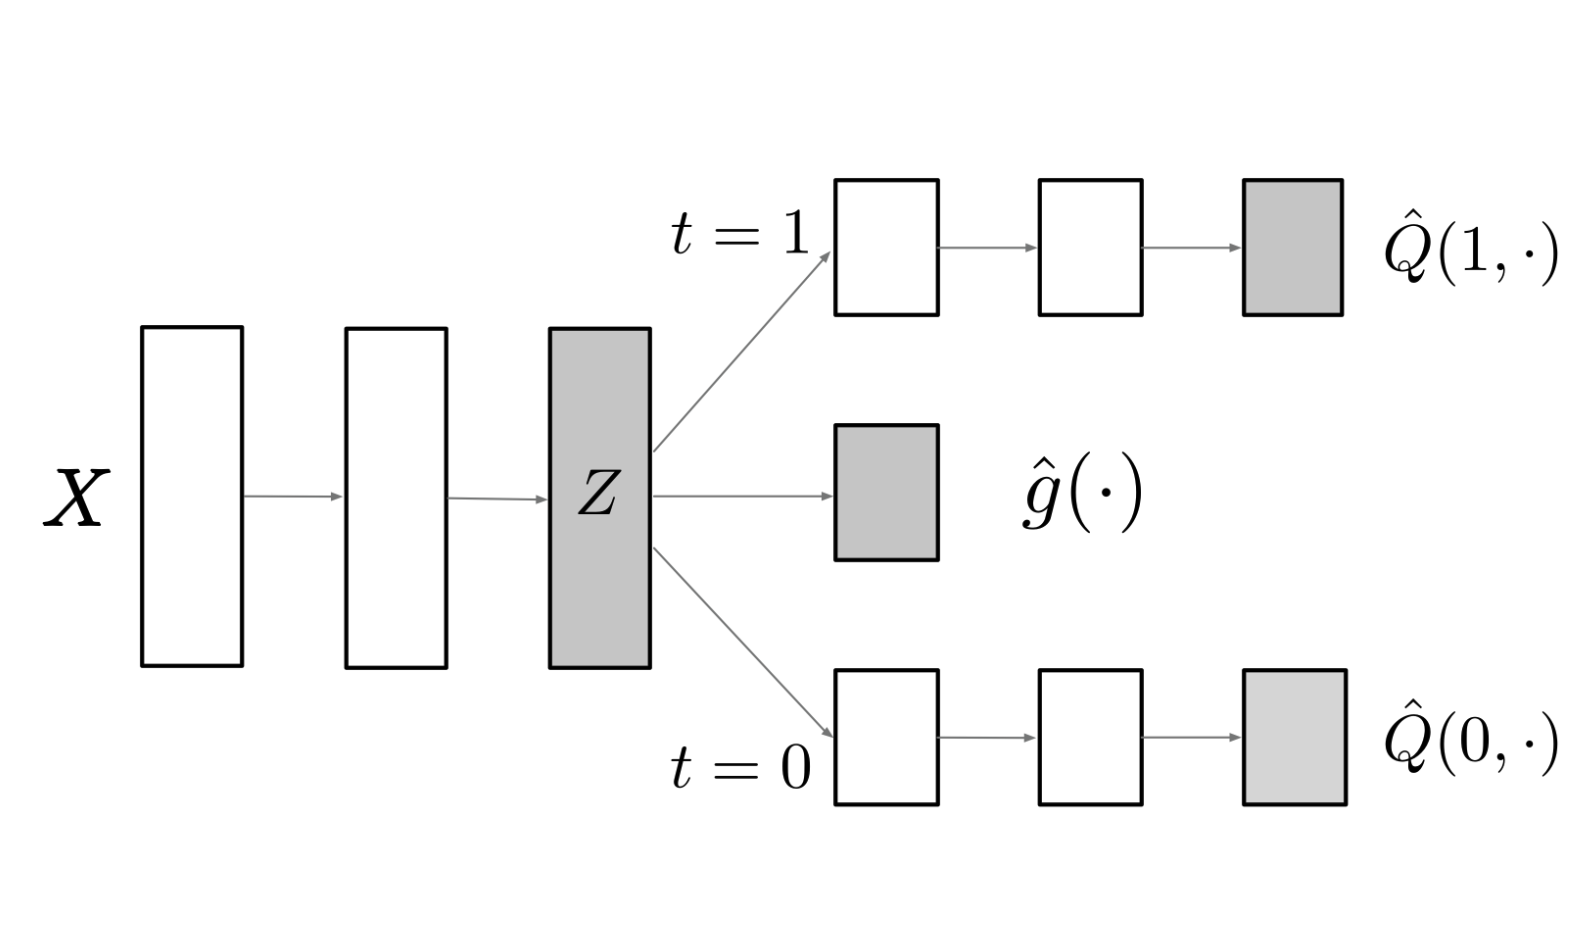



**Targeted Regularization **

**신경망으로 치료 효과 추정할 때, 학습 방식(손실 함수) 바꿔서 결과 품질 높이는 기법.**

**핵심 요약**

-   **목적**
    *   인과 효과 추정 모델(Q, g)이 통계적으로 **"좋은 특성(효율성, 강건성)"** 가지게 하려 함.
    *   기존 방식 유한 데이터에서 불안정 문제 있음.
-   **작동 원리**
    *   신경망 손실 함수에 특정 **"정규화 항"을 추가**함.
    *   이 정규화 항이 모델(Q:conditional outcome)을 미세하게 조정(epsilon 사용)**해서, 학습 과정에서 모델들이 **자동으로 원하는 통계적 방정식을 만족**하도록 유도함.
-   **결과:**
    *   **점근적 성능 좋음:** 데이터 많을수록 정확해짐.
    *   **데이터 효율 높음:** 적은 데이터에도 강함.
    *   **이중 강건성: Q(conditional outcome)나 g(propensity) 중 하나만 정확해도 됨.


In [19]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - binary_classification_loss: 47.6933 - loss: 30687.4219 - regression_loss: 15316.1367 - track_epsilon: 0.0482 - treatment_accuracy: 0.4655 - val_binary_classification_loss: 31.1635 - val_loss: 1606.6288 - val_regression_loss: 753.8831 - val_track_epsilon: 0.0467 - val_treatment_accuracy: 0.8104 - learning_rate: 0.0010
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - binary_classification_loss: 31.2255 - loss: 29422.9629 - regression_loss: 14690.3203 - track_epsilon: 0.0473 - treatment_accuracy: 0.8194 - val_binary_classification_loss: 30.4302 - val_loss: 6683.5874 - val_regression_loss: 3170.3279 - val_track_epsilon: 0.0446 - val_treatment_accuracy: 0.8104 - learning_rate: 0.0010
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - binary_classification_loss: 31.7955 - loss: 28654.0859 - regression_loss: 14301.8779 - track_epsilon: 0.0425 - treatment_accuracy: 0.8075 - val_binary_classification_loss: 30.1742 - val_loss: 6687.7212

In [20]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          tau.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','tau','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [21]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate, tau.mean()],
                     index=['S','T','X','R','dragonnet','actual'], columns=['ATE'])
df_result['MAE'] = [mean_absolute_error(t,p) for t,p in zip([s_ite, t_ite, x_ite, r_ite, np.nan_to_num(dragon_ite)],
                                                            [tau.values.reshape(-1,1)]*5 )
                ] + [None]
df_result['AUUC'] = auuc_score(df_preds)

In [22]:
df_result

,ATE,MAE,AUUC
S,4.727798,4.578659,0.684306
T,4.739772,4.686863,0.685586
X,4.750191,4.488349,0.675598
R,1.181827,6.013209,0.541989
dragonnet,4.617057,5.004309,0.682287
actual,4.759719,NaN,NaN


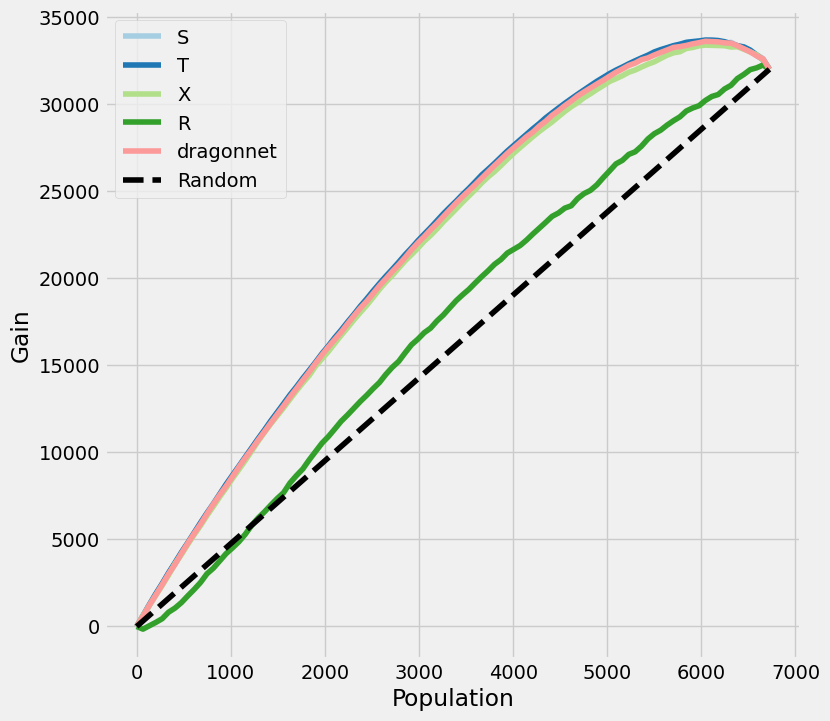

In [23]:
plot_gain(df_preds)


### 예측값 중, 차이가 가장 큰 항목 확인 (298 행)

In [37]:

# 예측값 중, 차이가 가장 큰 항목 확인 (298 행)
diff = t_ite.ravel() - dragon_ite.ravel()
diff_max_idx = diff.argmax() # 298 행
diff_max_idx

np.int64(298)

In [38]:

q1 = pd.DataFrame(X)
q2 = pd.DataFrame(treatment, columns=['treatment'])
q3 = pd.DataFrame(y.ravel(), columns=['y_factual'])
q4 = pd.DataFrame(tau.ravel(), columns=['tau_train'])

df_train_raw = pd.concat([q1, q2, q3, q4], axis = 1)
df_train_raw['s_leaner'] = s_ite.ravel()
df_train_raw['gragonnet'] = dragon_ite.ravel()


In [39]:
df_train_raw.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x21,x22,x23,x24,x25,treatment,y_factual,tau_train,s_leaner,gragonnet
count,6.723000e+03,6.723000e+03,6.723000e+03,6.723000e+03,6.723000e+03,6.723000e+03,6723.000000,6723.000000,6723.000000,6723.000000,...,6723.000000,6723.000000,6723.000000,6723.000000,6723.000000,6723.000000,6723.000000,6723.000000,6723.000000,6723.000000
mean,3.751936e-17,1.056883e-18,-2.430832e-17,-5.791721e-16,3.487715e-17,-7.567285e-16,0.514056,0.093708,0.520750,0.364123,...,0.156627,0.081660,0.073628,0.128514,0.157965,0.186078,8.876582,4.759719,4.727798,4.617057
std,9.994048e-01,9.994048e-01,9.994048e-01,9.994048e-01,9.994048e-01,9.994048e-01,0.499840,0.291444,0.499606,0.481219,...,0.363475,0.273866,0.261184,0.334686,0.364735,0.389198,14.309740,9.512967,2.991427,3.873073
min,-2.731287e+00,-3.800823e+00,-1.850350e+00,-8.796060e-01,-5.130428e+00,-1.851480e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.357794,-201.876774,-8.927632,-15.222116
25%,-6.777542e-01,-6.027100e-01,-7.332610e-01,-8.796060e-01,-5.666720e-01,-8.577868e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.567286,2.847961,3.099054,2.549951
50%,1.652752e-01,1.968181e-01,-3.608980e-01,1.617025e-01,1.210172e-01,-2.970882e-02,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.934160,4.273710,5.348492,5.495956
75%,8.137593e-01,5.965822e-01,7.561910e-01,1.617025e-01,6.836721e-01,6.327536e-01,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.142076,5.640515,6.894325,7.388426
max,1.505476e+00,2.595403e+00,2.990369e+00,2.244320e+00,2.371637e+00,2.951372e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.044346,45.493137,9.591181,11.012831


### 변수별 상관관계 분석

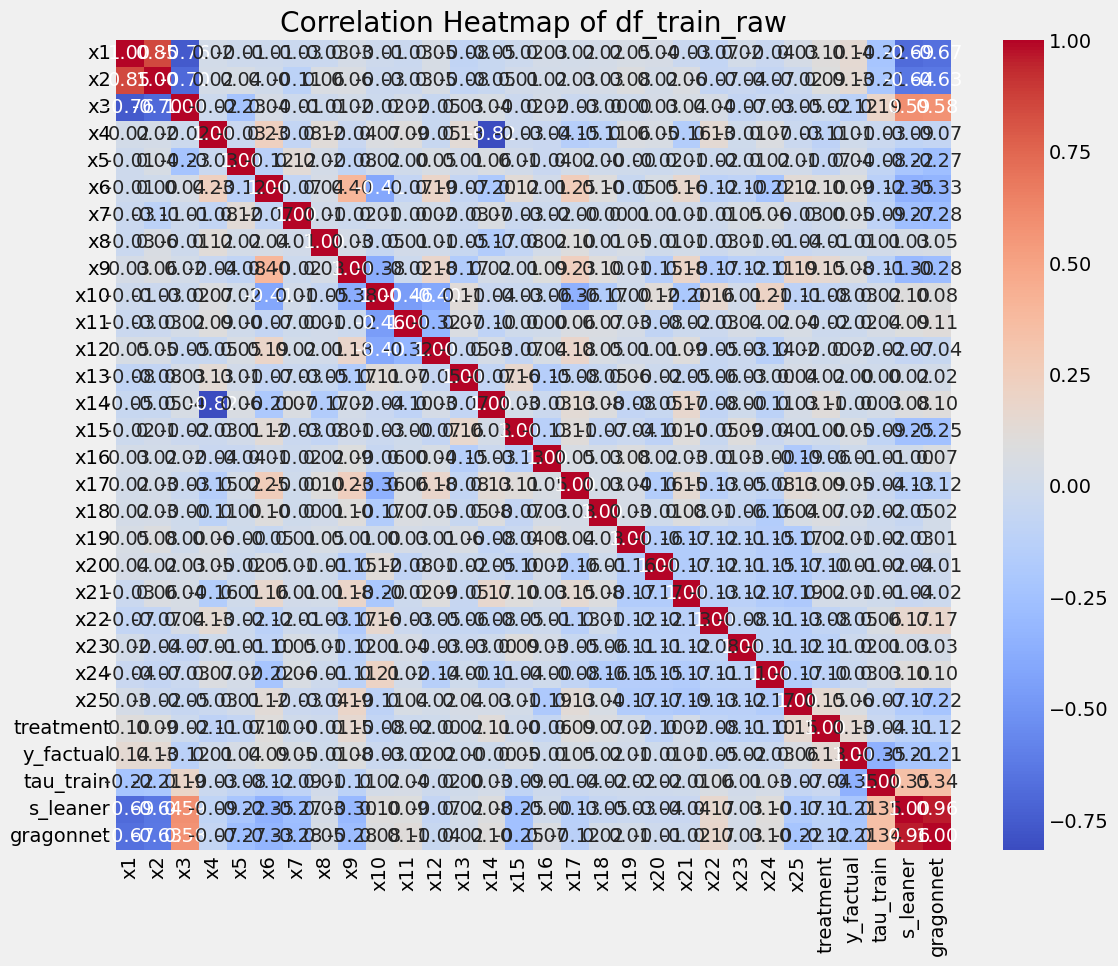

In [40]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_train_raw.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of df_train_raw')
plt.show()

In [41]:
correlation_matrix = df_train_raw.corr()
filtered_correlation_matrix = correlation_matrix[np.abs(correlation_matrix) > 0.7]


In [42]:
# Get the non-NaN values and their indices (row and column names)
strong_correlations = filtered_correlation_matrix.unstack().dropna()


strong_correlations

x1         x1           1.000000
           x2           0.846630
           x3          -0.757812
x2         x1           0.846630
           x2           1.000000
x3         x1          -0.757812
           x3           1.000000
x4         x4           1.000000
           x14         -0.817608
x5         x5           1.000000
x6         x6           1.000000
x7         x7           1.000000
x8         x8           1.000000
x9         x9           1.000000
x10        x10          1.000000
x11        x11          1.000000
x12        x12          1.000000
x13        x13          1.000000
x14        x4          -0.817608
           x14          1.000000
x15        x15          1.000000
x16        x16          1.000000
x17        x17          1.000000
x18        x18          1.000000
x19        x19          1.000000
x20        x20          1.000000
x21        x21          1.000000
x22        x22          1.000000
x23        x23          1.000000
x24        x24          1.000000
x25        x25          1.000000
treatment  treatment    1.000000
y_factual  y_factual    1.000000
tau_train  tau_train    1.000000
s_leaner   s_leaner     1.000000
           gragonnet    0.964022
gragonnet  s_leaner     0.964022
           gragonnet    1.000000
dtype: float64

| 변수  | 값 |   해석 요약 |
|------|----|-----------|
| x1&x2   | 0.846630 | 매우 강한 양의 상관관계가 있음 |
|   x1&x3    | -0.757812  | 매우 강한 음의 상관관계가 있음   |
| x4&x14  | -0.817608  |  매우 강한 음의 상관관계가 있음 |

-> x4와 x14는 각각 연속형, 범주형 변수로 보임

범주형 변수 분석

In [46]:
sbj=[f'x{i}'for i in range(7,26)]
for i in sbj:
  print(df_train_raw[i].value_counts(normalize=True))


x7
1    0.514056
0    0.485944
Name: proportion, dtype: float64
x8
0    0.906292
1    0.093708
Name: proportion, dtype: float64
x9
1    0.52075
0    0.47925
Name: proportion, dtype: float64
x10
0    0.635877
1    0.364123
Name: proportion, dtype: float64
x11
0    0.730924
1    0.269076
Name: proportion, dtype: float64
x12
0    0.780455
1    0.219545
Name: proportion, dtype: float64
x13
0    0.641232
1    0.358768
Name: proportion, dtype: float64
x14
1    0.536814
2    0.463186
Name: proportion, dtype: float64
x15
0    0.859438
1    0.140562
Name: proportion, dtype: float64
x16
1    0.959839
0    0.040161
Name: proportion, dtype: float64
x17
1    0.594378
0    0.405622
Name: proportion, dtype: float64
x18
1    0.963855
0    0.036145
Name: proportion, dtype: float64
x19
0    0.864793
1    0.135207
Name: proportion, dtype: float64
x20
0    0.864793
1    0.135207
Name: proportion, dtype: float64
x21
0    0.843373
1    0.156627
Name: proportion, dtype: float64
x22
0    0.91834
1    0.08166


| 변수  | 값 | 비율(%)  | 해석 요약 |
|------|----|---------|-----------|
| x7   | 1  | 51.4    | 0과 1이 균형적 |
|      | 0  | 48.6    | |
| x8   | 0  | 90.6    | 0이 압도적 |
|      | 1  | 9.4     | |
| x9   | 1  | 52.1    | 균형적 |
|      | 0  | 47.9    | |
| x10  | 0  | 63.6    | 0이 우세 |
|      | 1  | 36.4    | |
| x11  | 0  | 73.1    | 0이 다수 |
|      | 1  | 26.9    | |
| x12  | 0  | 78.0    | 0이 많음 |
|      | 1  | 22.0    | |
| x13  | 0  | 64.1    | 0이 많음 |
|      | 1  | 35.9    | |
| x14  | 1  | 53.7    | 1과 2가 균형적 |
|      | 2  | 46.3    | |
| x15  | 0  | 85.9    | 0이 압도적 |
|      | 1  | 14.1    | |
| x16  | 1  | 96.0    | 거의 전부 1 |
|      | 0  | 4.0     | |
| x17  | 1  | 59.4    | 1이 다수 |
|      | 0  | 40.6    | |
| x18  | 1  | 96.4    | 거의 전부 1 |
|      | 0  | 3.6     | |
| x19  | 0  | 86.5    | 0이 압도적 |
|      | 1  | 13.5    | |
| x20  | 0  | 86.5    | x19와 동일 |
|      | 1  | 13.5    | |
| x21  | 0  | 84.3    | 0이 압도적 |
|      | 1  | 15.7    | |
| x22  | 0  | 91.8    | 0이 절대 다수 |
|      | 1  | 8.2     | |
| x23  | 0  | 92.6    | 0이 절대 다수 |
|      | 1  | 7.4     | |
| x24  | 0  | 87.1    | 0이 압도적 |
|      | 1  | 12.9    | |
| x25  | 0  | 84.2    | 0이 압도적 |
|      | 1  | 15.8    | |


특이하게 x14변수만 1와2의 값을 가지고 있음

In [47]:

df_train_raw.iloc[diff_max_idx]


,298
x1,1.343355
x2,1.795874
x3,-1.105624
x4,-0.879606
x5,-0.691706
x6,0.798369
x7,1.000000
x8,0.000000
x9,1.000000
x10,0.000000


각 변수별

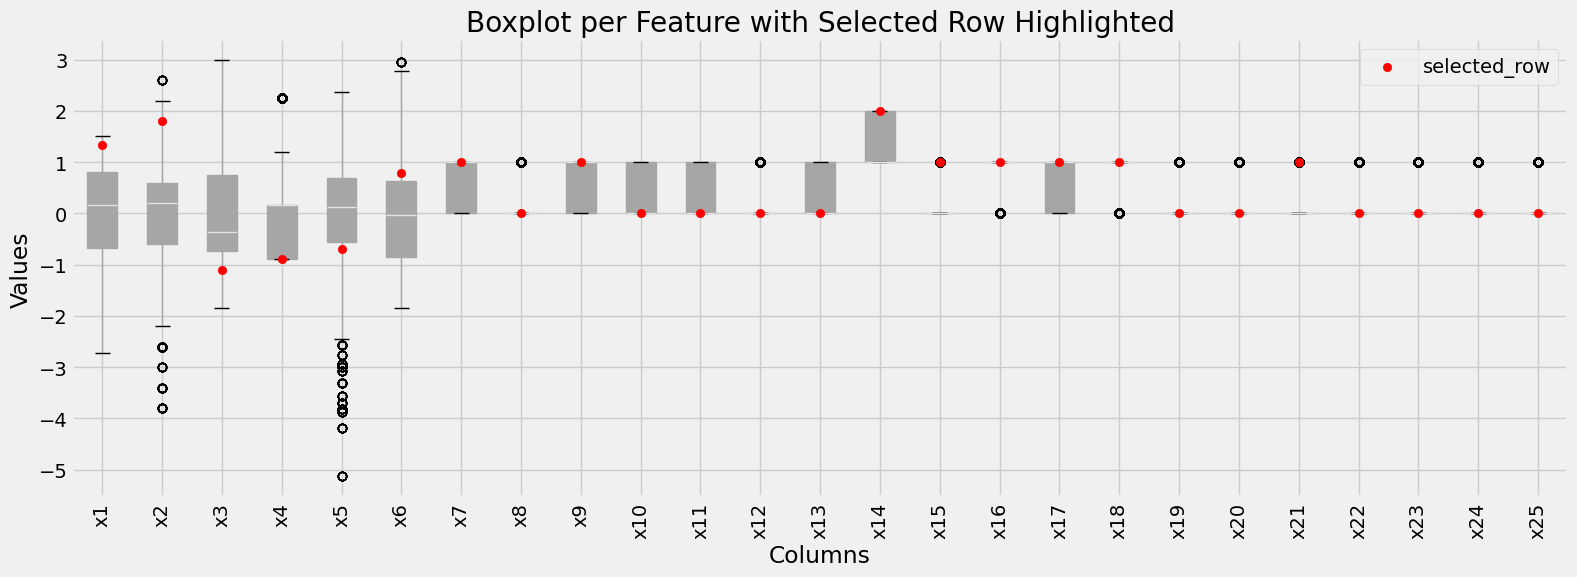

In [48]:


# describe 결과 (df.describe())
desc = df_train_raw.describe().iloc[:,:-5]

# 비교 대상 row
row_values = df_train_raw.iloc[diff_max_idx,:-5]

plt.figure(figsize=(16,6))

# ✅ 원본 데이터로 boxplot 생성
df_train_raw.iloc[:,:-5].boxplot(grid=False, patch_artist=True)

# ✅ selected_row 값 빨간 점으로 표시
for i, col in enumerate(df_train_raw.columns[:-5], start=1):
    plt.scatter(i, row_values[col], color="red", zorder=3,
                label="selected_row" if i==1 else "")

plt.title("Boxplot per Feature with Selected Row Highlighted")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


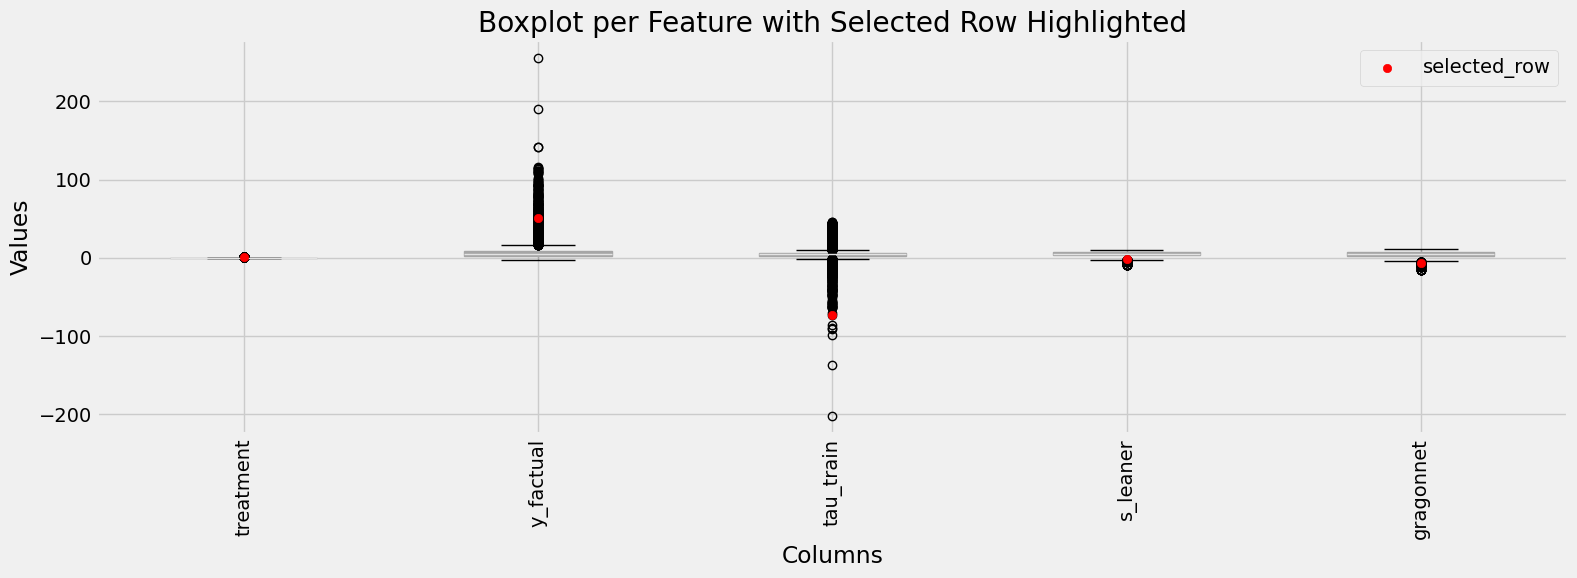

In [49]:


# describe 결과 (df.describe())
desc = df_train_raw.describe().iloc[:,-5:]

# 비교 대상 row
row_values = df_train_raw.iloc[diff_max_idx,-5:]

plt.figure(figsize=(16,6))

# ✅ 원본 데이터로 boxplot 생성
df_train_raw.iloc[:,-5:].boxplot(grid=False, patch_artist=True)

# ✅ selected_row 값 빨간 점으로 표시
for i, col in enumerate(df_train_raw.columns[-5:], start=1):
    plt.scatter(i, row_values[col], color="red", zorder=3,
                label="selected_row" if i==1 else "")

plt.title("Boxplot per Feature with Selected Row Highlighted")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.xticks(rotation=90)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [56]:
from lightgbm import LGBMRegressor

# treated, control 분리
X_treat = X[treatment == 1]
y_treat = y[treatment == 1]

X_ctrl = X[treatment == 0]
y_ctrl = y[treatment == 0]

# 모델 훈련
model_t = LGBMRegressor().fit(X_treat, y_treat)
model_c = LGBMRegressor().fit(X_ctrl, y_ctrl)

# 중요도 보기
feat_names = X.columns if hasattr(X, 'columns') else [f'x{i+1}' for i in range(X.shape[1])]
imp_t = pd.Series(model_t.feature_importances_, index=feat_names).rename("treated")
imp_c = pd.Series(model_c.feature_importances_, index=feat_names).rename("control")
imp_avg = ((imp_t + imp_c) / 2).rename("average")
feat_importance = pd.concat([imp_t, imp_c, imp_avg], axis=1).sort_values("average", ascending=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 256
[LightGBM] [Info] Number of data points in the train set: 1251, number of used features: 23
[LightGBM] [Info] Start training from score 12.903212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 416
[LightGBM] [Info] Number of data points in the train set: 5472, number of used features: 25
[LightGBM] [Info] Start training from score 7.956020


In [60]:
feat_importance

,treated,control,average
x1,682,511,596.5
x5,643,489,566.0
x6,378,478,428.0
x2,303,224,263.5
x3,262,194,228.0
x4,106,127,116.5
x7,100,133,116.5
x25,73,90,81.5
x10,69,88,78.5
x15,20,107,63.5


In [62]:
print(df_train_raw['x4'].value_counts())
print(df_train_raw['x14'].value_counts())

x4
-0.879606    3114
 0.161703    2124
 1.203011     900
 2.244320     585
Name: count, dtype: int64
x14
1    3609
2    3114
Name: count, dtype: int64


Text(0, 0.5, 'x14')

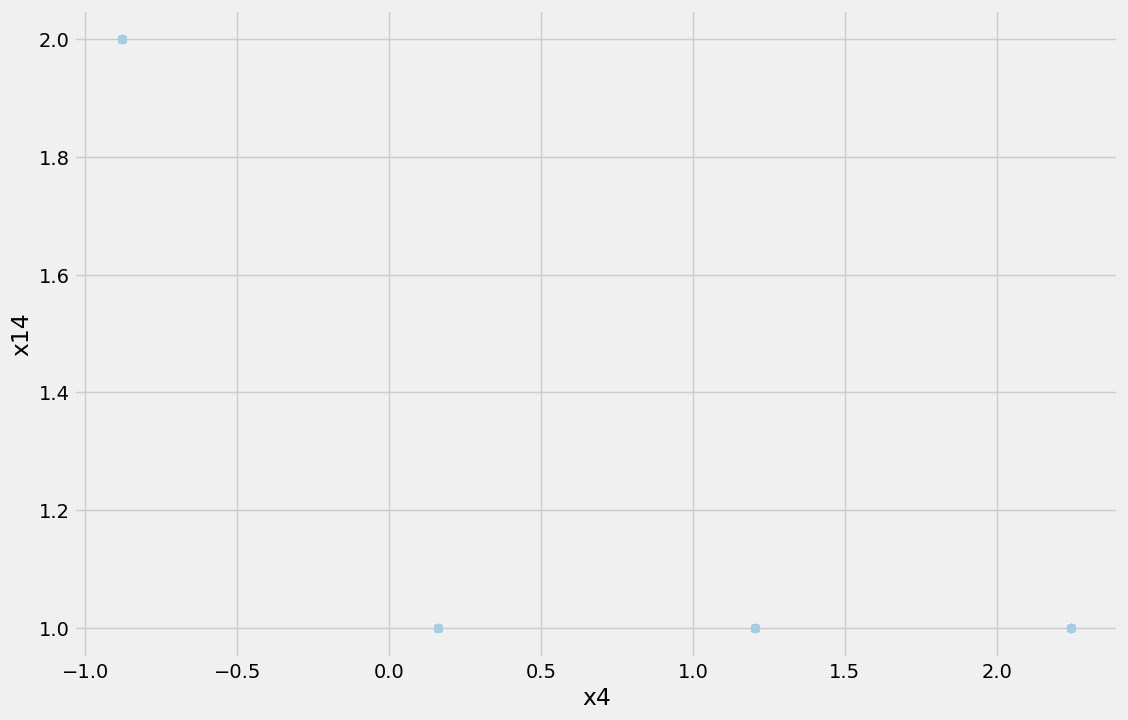

In [61]:
plt.scatter(df_train_raw['x4'], df_train_raw['x14'])
plt.xlabel('x4')
plt.ylabel('x14')

변수 x4와 x14는 강한 상관관계를 가지며, 실제로 x14는 x4를 이진화한 형태로 해석될 수 있다.
예를 들어, x4 < 0인 경우 대부분 x14 = 2, 그렇지 않은 경우 x14 = 1로 매핑된다.
그러나 모델의 feature importance 분석 결과, x14는 거의 사용되지 않고 x4의 중요도가 높게 나타났다.
이는 x14가 이진형 변수로서 정보량이 제한적인 반면, x4는 연속형으로 더 다양한 split 기준을 제공할 수 있어 모델 학습에 유리했기 때문으로 판단된다.



### 샘플 298 분석

샘플 298은 처치를 받은 경우였고, 관측된 결과는 51.36이었다. 하지만 실제 개별 처치 효과(ITE)는 -73.67로, 처치를 받지 않았다면 약 125 정도의 결과가 나왔을 것으로 보인다. 즉, 처치로 인해 성과가 크게 떨어진 사례다.

모델 예측 결과는 아래와 같다.

|모델|	예측 ITE|
|------|----|
|S-learner|	-0.91|
|DragonNet|	-7.16|

두 모델 모두 방향은 맞췄지만, 효과 크기를 심하게 과소평가했다. 특히 S-learner는 거의 영향을 받지 않은 것으로 판단했다.

이 샘플의 주요 특징을 살펴보면, x2는 1.80으로 전체 분포 중 상위권에 해당하며, x4 = -0.88로 낮은 값을 가진다. 이때 x14 = 2인데, x4 < 0일 때 x14 = 2인 경우가 많았기 때문에 두 변수 간 상관관계가 높은 것으로 보인다. 실제로 모델에서 x14는 중요도가 0에 가까웠고, 연속형 변수인 x4가 주요한 분류 기준으로 사용됐다. 같은 정보를 가진 두 변수 중, 모델은 더 세밀한 스플릿이 가능한 x4만 활용한 것으로 해석할 수 있다.

또한 x15부터 x18까지 모두 1인 상태였는데, LightGBM의 feature importance 기준에서 이 변수들은 상대적으로 높은 중요도를 갖고 있었다. 이는 학습 데이터 전반에서 해당 변수들이 결과 변화에 영향을 준 변수로 작용했다는 간접적 근거가 된다. 따라서, 이 샘플은 여러 개의 영향력 있는 변수들이 동시에 특정 방향으로 설정되어 있었고, 그 조합이 결과적으로 부정적 처치 효과를 강화했을 가능성이 있다.

다만, 이러한 피처 조합은 전체 데이터에서 드문 편에 속했고, 특히 x14 = 2와 같이 희귀한 값은 모델 학습 시 충분히 반영되지 않았을 수 있다. 이로 인해 모델이 실제보다 작게 처치 효과를 예측했을 가능성이 있다.

정리하면, 샘플 298은 드물고 극단적인 처치 효과를 가진 사례로, 모델은 방향성은 맞췄지만 크기를 반영하지 못했다. 희귀한 범주형 변수와 높은 중요도를 가진 피처들의 조합이 학습 데이터에서 충분히 포착되지 못했을 가능성이 있으며, 이는 예측 정확도에 부정적인 영향을 준 것으로 해석된다.